In [7]:
import torch
import torch.nn as nn
from torch import tensor as Tensor
import matplotlib.pyplot as plt
from math import exp

N = 10
h = 1.0 / N
eps = -1.0
deg = 2
sigma = 10.0 * deg * deg
X = torch.linspace(0, 1, N+1)
Nint = 50

def source(x):
    return (4*x**3 - 4*x**2-6*x + 2) * torch.exp(-x**2)

def exact(x):
    return (1-x)*torch.exp(-x**2)

###################################################### Particle test function ##########################################################
def particletest(r):
    '''particle test function in the nth cell, 0<r<1'''
    if r <= 1+1e-6 and r>-1e-6:
        return (1-r)**5 * (8*r**2+5*r+1)
    else:
        print("r>1, somthing went wrong!")
        return 0


def grad_particletest(r):
    ''' gradient of test function on the reference cell, only accept r'''
    if r <= 1+1e-6 and r>-1e-6:
        return -14*r*(4*r+1)*(1-r)**4
    else:
        print(r, "r>1, somthing went wrong!")
        return 0

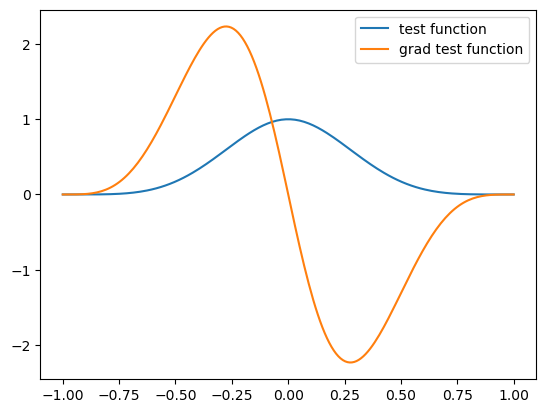

In [9]:
############################################## test the particle test function ##################################################
x1 = torch.linspace(0,1,100)
x2 = torch.linspace(-1,0,100)
r = -x2
y1 = torch.zeros_like(x1)
y2 = torch.zeros_like(x2)
gy1 = torch.zeros_like(x1)
gy2 = torch.zeros_like(x2)
for i in range(x1.shape[0]):
    y1[i] = particletest(x1[i])
    y2[i] = particletest(r[i])
    gy1[i] = grad_particletest(x1[i])
    gy2[i] = -grad_particletest(r[i])
x = torch.cat((x2, x1))  
y = torch.cat((y2, y1)) 
gy = torch.cat((gy2, gy1)) 
plt.plot(x,y,label='test function')
plt.plot(x, gy,label='grad test function')
plt.legend()  
plt.show()

In [3]:
class net(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Linear(1, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 1)
    def forward(self, x):
        o1 = torch.tanh(self.layer1(x))
        o2 = torch.tanh(self.layer2(o1))
        op = self.layer3(o2)
        return op

import numpy as np

def ref2phi(s, n):
    ''' s is the position of one dim'''
    return (s + 1) / 2.0 * (X[n+1] - X[n]) + X[n]

def phi2ref(x, n):
    xm = (X[n] + X[n+1])/2.0
    return abs(x - xm)/(- X[n] + X[n+1])*2.0 



def computeP(net: net):
    particleloss = Tensor([0.0])
    for n in range(N):
        P = Tensor([0.0])
        hn = X[n+1] - X[n]
        
        s = np.linspace(X[n], X[n+1], Nint, endpoint=False)
        xm = (X[n+1] + X[n]) / 2.0
        for k in range(Nint-2):
            p = Tensor([s[k]], requires_grad=True, dtype=torch.float32)
            up = net(p)
            gup = torch.autograd.grad(up, p, create_graph=True, retain_graph=True)[0]
            r = phi2ref(s[k], n)
            # print(k, s[k], 'r', r)
            gptf = grad_particletest(r)
            if p - xm < 0:
                gr = -2.0 / hn
            else:
                gr = 2.0 / hn
            f = source(p)
            ptf = particletest(r)
            P += 1.0 / Nint * (gup * gptf * gr - f * ptf) * hn
        particleloss += P**2
    return particleloss
model = net()
print(computeP(model))


tensor([0.0197], grad_fn=<AddBackward0>)


In [5]:
def computebd(net: net):
    bdloss = (net(Tensor([X[0]]))- Tensor([1.0]))**2
    bdloss += (net(Tensor([X[N]])))**2
    return bdloss

print(computebd(model))

tensor([1.0196], grad_fn=<AddBackward0>)


In [6]:
class DGNet:
    def __init__(self) -> None:
        self.model = net()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-2)
        self.maxIter = 1000
        self.iter = 1
    
    def loss(self):
        particleloss = computeP(self.model) / (N)
        bdloss = 5.0 * computebd(self.model) / 2
        loss = particleloss + bdloss 
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(f"The {self.iter}th training, loss is {loss.item()}: paricleloss is {particleloss.item()},  bdloss is {bdloss.item()}")
        return loss
    
    def train(self, niter):
        self.model.train()
        for _ in range(niter):
            self.optimizer.zero_grad()
            loss = self.loss()
            if loss < 1e-4:
                print(f"The {self.iter}th training, loss is {loss.item()}")
                break
            loss.backward()
            self.optimizer.step()

net = DGNet()
net.train(1000)

The 100th training, loss is 0.0017066641012206674: paricleloss is 0.0016879488248378038,  bdloss is 1.8715247279033065e-05
The 200th training, loss is 0.001402824418619275: paricleloss is 0.001402618712745607,  bdloss is 2.0567554770423158e-07
The 300th training, loss is 0.0011115107918158174: paricleloss is 0.0011112878564745188,  bdloss is 2.229023721156409e-07
The 400th training, loss is 0.0008453248301520944: paricleloss is 0.0008450722089037299,  bdloss is 2.5260197844545473e-07
The 500th training, loss is 0.0005983010050840676: paricleloss is 0.0005980393616482615,  bdloss is 2.616212100292614e-07
The 600th training, loss is 0.000368336885003373: paricleloss is 0.00036811851896345615,  bdloss is 2.183722358495288e-07
The 700th training, loss is 0.00018663906666915864: paricleloss is 0.00018650769197847694,  bdloss is 1.3137386645212246e-07
The 780th training, loss is 9.957396105164662e-05


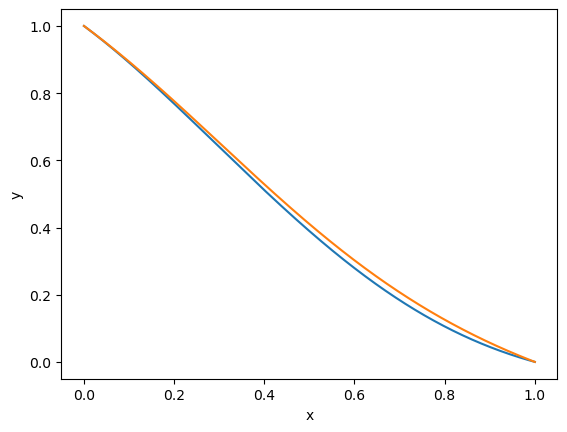

In [7]:
import matplotlib.pyplot as plt  
import numpy as np

bfl = net.model
    

################################# plot exact solution ###################################
x_values = np.linspace(0, 1, 1000)  # 生成 x 值  
y_values = (1 - x_values) * np.exp(-x_values**2)  # 计算对应的 y 值  
plt.plot(x_values, y_values, label='(1-x)e^x)')  

x = np.linspace(0, 1, 1000)  # 生成 x 值 
y = np.zeros_like(x)
for i in range(x.shape[0]):
    p = Tensor([x[i]], requires_grad=True, dtype=torch.float32)
    y[i] = bfl(p)  
plt.plot(x,y)
plt.xlabel('x')  
plt.ylabel('y')  
plt.show() 